# **Malaria Detection**

##<b>Problem Definition</b>
**The context:** Why is this problem important to solve?<br>
**The objectives:** What is the intended goal?<br>
**The key questions:** What are the key questions that need to be answered?<br>
**The problem formulation:** What is it that we are trying to solve using data science?

## <b>Data Description </b>

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


###<b> Mount the Drive

In [2]:
# ran locally

### <b>Loading libraries</b>

In [3]:
import tensorflow
from tensorflow import keras
from keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.config import disable_traceback_filtering
from keras import utils

import numpy as np
from PIL import Image

from collections import Counter

import matplotlib.pyplot as plt


print("TensorFlow version:", tensorflow.__version__)

# ensure gpu acceleration is available
print(tensorflow.config.list_physical_devices('GPU'))
    #   .list_physical_devices('GPU'))




TensorFlow version: 2.18.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### <b>Let us load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same to your Google Drive. Then unzip the folder.

In [4]:
# Define paths to the train and test directories
train_dir = "./cell_images/train"
test_dir = "./cell_images/test"

# Import a single image from the training dataset to check the size
sample_image_path = f"{train_dir}/parasitized/C6NThinF_IMG_20150609_122327_cell_119.png"  # Example path
sample_image = Image.open(sample_image_path)


# Import a single image from the test dataset
sample_test_image_path = f"{test_dir}/parasitized/C39P4thinF_original_IMG_20150622_105253_cell_92.png"  # Example path
sample_test_image = Image.open(sample_test_image_path)

# Check the size of the image
print("Sample train image size:", sample_image.size)
# Check the size of the test image
print("Sample test image size:", sample_test_image.size)



Sample train image size: (133, 136)
Sample test image size: (139, 163)


The extracted folder has different folders for train and test data will contain the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [5]:
# Resize the image to 128x128 because this is similar to the size used in the dataset

# Load training data
train_dataset = utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",  # Automatically infer labels from subfolder names
    label_mode="binary",  # Use binary labels for parasitized/uninfected
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=None,  # Load all images in the training set without batching
)

# Load testing data
test_dataset = utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="binary",
    image_size=(128, 128),  # Resize images to 128x128
    batch_size=None # Load all images in the test set without batching
)

print("\nTraining dataset:")
data_shapes = []
label_shapes = []
for data, labels in train_dataset:
    data_shapes.append(data.shape)
    label_shapes.append(labels.shape)

print("Number of samples in training dataset:", len(data_shapes))
print("Data shape (example):", data_shapes[0])
print("Labels shape (example):", label_shapes[0])


print("\nTesting dataset:")
test_data_shapes = []
test_label_shapes = []
for data, labels in test_dataset:
    test_data_shapes.append(data.shape)
    test_label_shapes.append(labels.shape)

print("Number of samples in testing dataset:", len(test_data_shapes))
print("Data shape (example):", test_data_shapes[0])
print("Labels shape (example):", test_label_shapes[0])

Found 24958 files belonging to 2 classes.
Found 2600 files belonging to 2 classes.

Training dataset:


2025-04-11 15:31:01.905172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-11 15:31:01.905205: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-11 15:31:01.905211: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1744381861.905232 6211084 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1744381861.905256 6211084 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Number of samples in training dataset: 24958
Data shape (example): (128, 128, 3)
Labels shape (example): (1,)

Testing dataset:
Number of samples in testing dataset: 2600
Data shape (example): (128, 128, 3)
Labels shape (example): (1,)


2025-04-11 15:31:03.510979: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-11 15:31:03.705772: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


###<b> Check the shape of train and test images

In [6]:
im = train_dataset.take(1).get_single_element(0)
im[1].numpy()[0]

np.float32(0.0)

###<b> Check the shape of train and test labels

In [7]:
# check shape of train and test labels
print("\nTraining label shape:", train_dataset.take(1).get_single_element()[1].shape)
print("Testing label shape:", test_dataset.take(1).get_single_element()[1].shape)


Training label shape: (1,)
Testing label shape: (1,)


### Observations and insights:

The images have all been resized to 128x128x3, the third dimenstion being the RGB components of the image.

Overall the dataset is 4D when accounting for multiple images.

There about 10x more training data than test data.

Resizing the images to 128x128 may result in a small amount of data loss because the images are larger than this sometimes. Should have resized images to 150x150.


### <b>Check the minimum and maximum range of pixel values for train and test images

In [8]:
np_train = train_dataset.as_numpy_iterator()
np_test = test_dataset.as_numpy_iterator()

# get the data and labels
np_train.next()
np_test.next()

# remove the labels and just keep the images
train_images = []
for data, labels in np_train:
    train_images.append(data)
train_images = np.array(train_images)


test_images = []
for data, labels in np_test:
    test_images.append(data)
test_images = np.array(test_images)

# get max and min values for test and training images
max_value = np.max(test_images)
min_value = np.min(test_images)
print("Max value in test images:", max_value)
print("Min value in test images:", min_value)

max_value = np.max(train_images)
min_value = np.min(train_images)
print("Max value in training images:", max_value)
print("Min value in training images:", min_value)


2025-04-11 15:31:08.438511: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Max value in test images: 255.0
Min value in test images: 0.0
Max value in training images: 255.0
Min value in training images: 0.0


We can see the pixel values range from 0-255

In [9]:

# Normalize the pixel values to be between 0 and 1
def normalize(image):
    return image / 255.0
# Apply normalization to the training dataset
train_dataset_norm = train_dataset.map(lambda x, y: (normalize(x), y))
# Apply normalization to the testing dataset
test_dataset_norm = test_dataset.map(lambda x, y: (normalize(x), y))
# Check the pixel value range after normalization
sample_train_image = train_dataset_norm.take(1).get_single_element()[0]
sample_test_image = test_dataset_norm.take(1).get_single_element()[0]
print("\nSample train image pixel value range after normalization:", np.min(sample_train_image), '--',np.max(sample_train_image))
print("Sample test image pixel value range after normalization:", np.min(sample_test_image), '--',np.max(sample_test_image))


Sample train image pixel value range after normalization: 0.0 -- 0.8621471
Sample test image pixel value range after normalization: 0.0 -- 0.83438575


### Observations and insights: 

Pre-normalization, the pixel values ranged from 0-255. 

I have normalized the pixel values to 0-1 to improve model training stability, which will accelerate model convergence and has the added benefit of consistency across datasets and will facilitate comparisons with pre-trained models.


###<b> Count the number of values in both uninfected and parasitized 

In [10]:
print(train_dataset.cardinality())
print(test_dataset.cardinality())


tf.Tensor(24958, shape=(), dtype=int64)
tf.Tensor(2600, shape=(), dtype=int64)


###<b>Normalize the images

In [11]:
# Already normalized above

#### Observations and insights:

About 90% of data is training data, and 10% is testing data.

###<b> Plot to check if the data is balanced

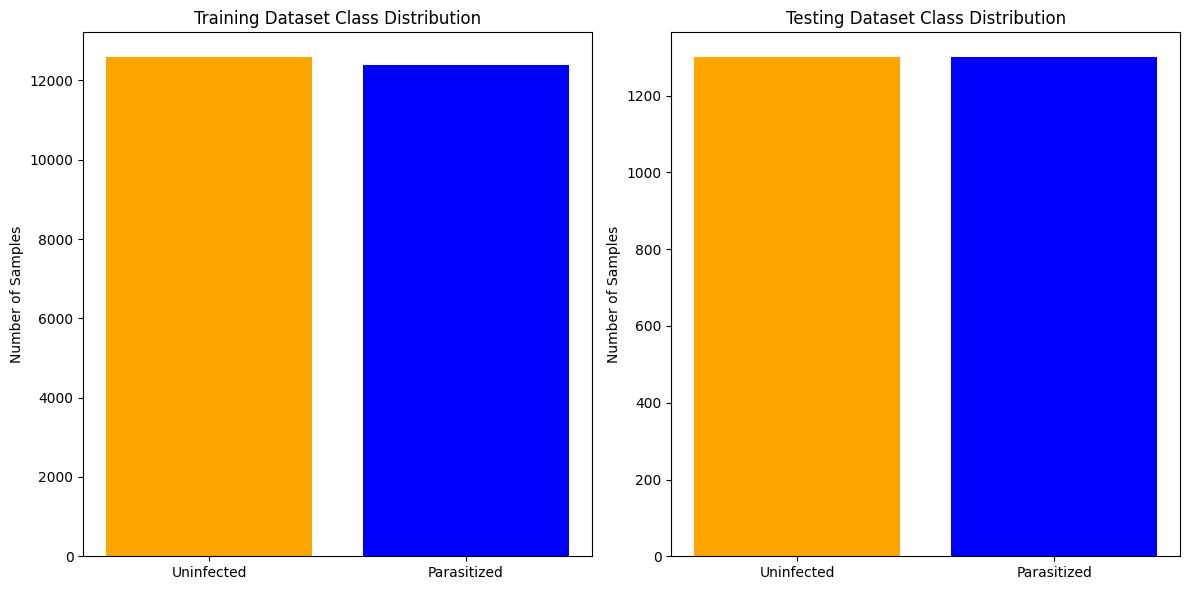

In [12]:
# Count the number of samples for each class in the training dataset
train_labels = [label.numpy()[0] for _, label in train_dataset_norm]
train_label_counts = Counter(train_labels)

# Count the number of samples for each class in the testing dataset
test_labels = [label.numpy()[0] for _, label in test_dataset_norm]
test_label_counts = Counter(test_labels)

# Plot the counts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Training dataset
ax[0].bar(train_label_counts.keys(), train_label_counts.values(), color=['blue', 'orange'])
ax[0].set_title("Training Dataset Class Distribution")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Uninfected', 'Parasitized'])
ax[0].set_ylabel("Number of Samples")

# Testing dataset
ax[1].bar(test_label_counts.keys(), test_label_counts.values(), color=['blue', 'orange'])
ax[1].set_title("Testing Dataset Class Distribution")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Uninfected', 'Parasitized'])
ax[1].set_ylabel("Number of Samples")

plt.tight_layout()
plt.show()


####<b> Observations and insights: _____

From the plot, we can see the dataset is well balanced. This will prevent our model from becoming skewed - for example: very good at identifying uninfected cells, but bad at identifying parasitized cells.

### <b>Data Exploration</b>
Let's visualize the images from the train data

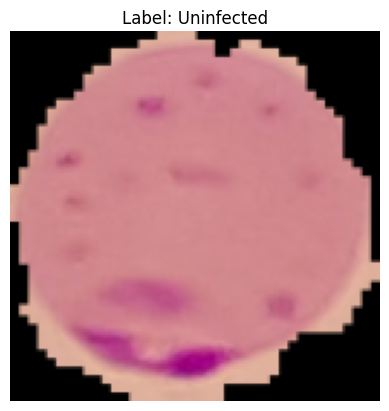

In [13]:
# Visualize one of the training images
for image, label in train_dataset_norm.take(1):
    plt.imshow(image.numpy())
    plt.title(f"Label: {'Parasitized' if label.numpy()[0] == 1.0 else 'Uninfected'}")
    plt.axis('off')
    plt.show()

### Observations and insights:

The image has been cropped to only show 1 whole blood cell. This should remove noise in the data but may cause the model to overfit, because the training and test data may be cleaner than real-world data.


###<b> Visualize the images with subplot(6, 6) and figsize = (12, 12)

2025-04-11 15:31:12.103637: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


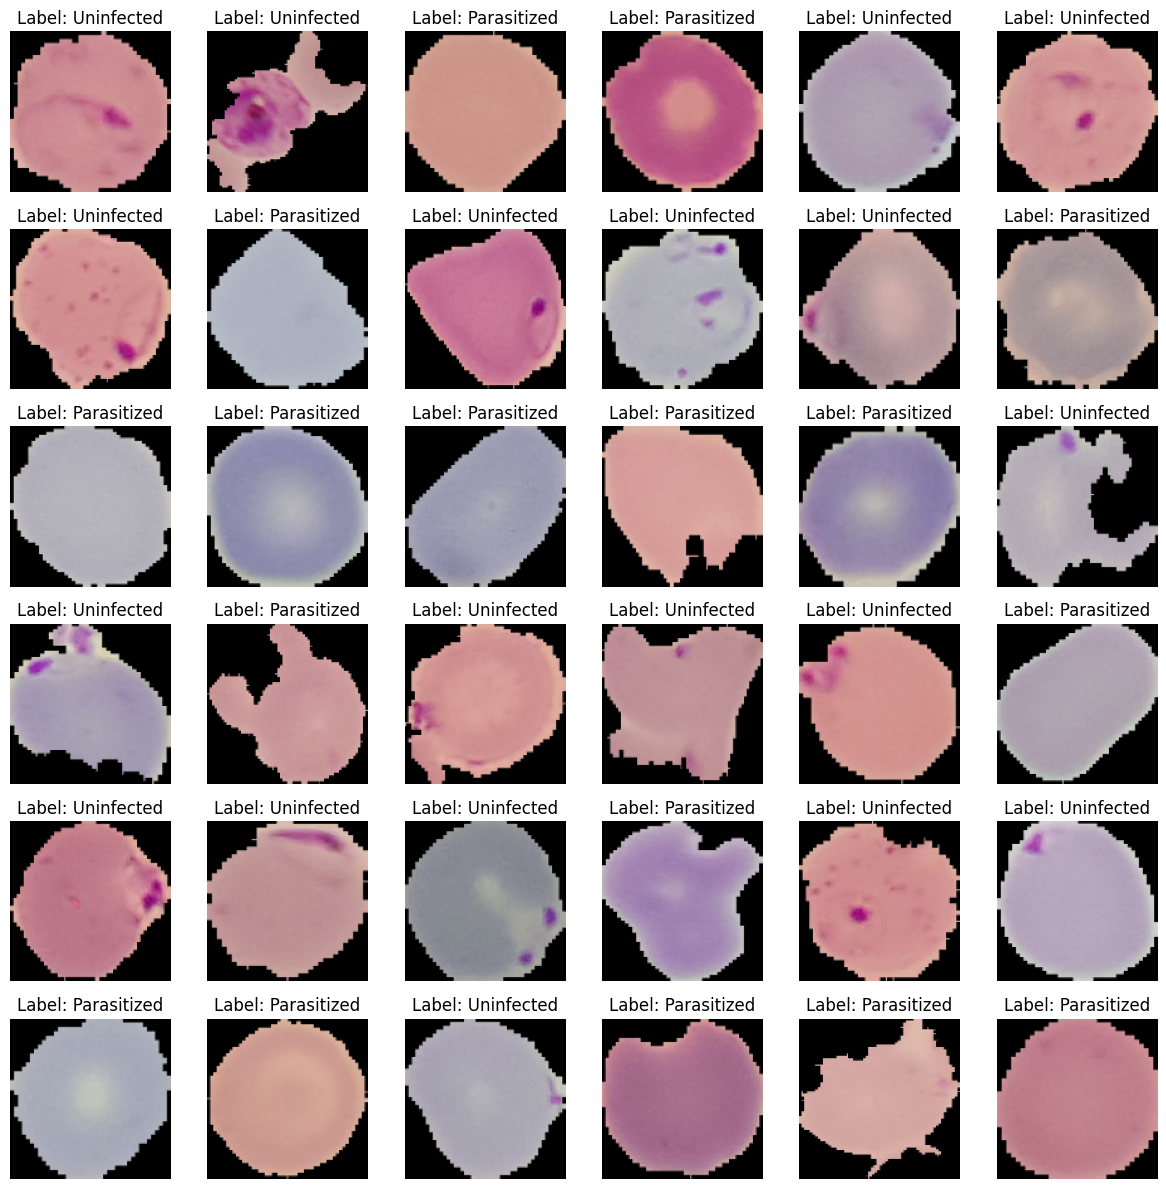

In [14]:
# Visualize 36 images from the training dataset in a grid
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_dataset_norm.take(36)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {'Parasitized' if label.numpy()[0] == 1.0 else 'Uninfected'}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Observations and insights:

There is no obvious different between a healthy and malarial blood cell, so it may be difficult for a human to identify the differences by eye. So machine learning is the ideal application for this!

###<b> Plotting the mean images for parasitized and uninfected

In [15]:
# split the dataset into parasitized and uninfected images
parasitized_images = [image.numpy() for image, label in train_dataset_norm if label.numpy()[0] == 1.0]
uninfected_images = [image.numpy() for image, label in train_dataset_norm if label.numpy()[0] == 0.0]


# Compute the mean image
mean_parasitized_image = np.mean(parasitized_images, axis=0)
mean_uninfected_image = np.mean(uninfected_images, axis=0)

print("Mean parasitized image shape:", mean_parasitized_image.shape)
print("Mean image shape:", mean_parasitized_image.shape)



Mean parasitized image shape: (128, 128, 3)
Mean image shape: (128, 128, 3)


<b> Mean image for parasitized

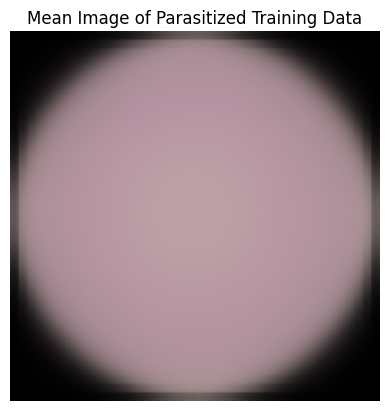

In [16]:
# Plot the mean image
plt.imshow(mean_parasitized_image)
plt.title("Mean Image of Parasitized Training Data")
plt.axis('off')
plt.show()

<b> Mean image for uninfected

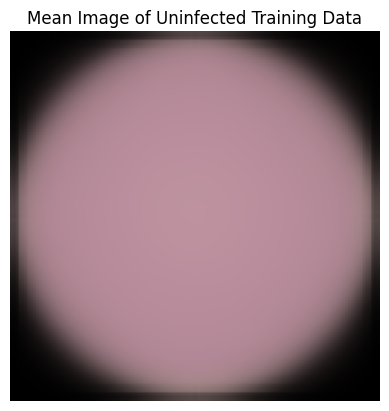

In [17]:
# plot the mean image of uninfected training data
plt.imshow(mean_uninfected_image)
plt.title("Mean Image of Uninfected Training Data")
plt.axis('off')
plt.show()

### Observations and insights: 

Very similar for uninfected and parasitized, suggesting that there is no overall pattern in the images from each class to suggest if a blood cell is infected or not.

This suggests a fully connected NN will perform poorly, because there are no area-specific parts of the image that are important, the important features lie in smaller sections that can appear anywhere.

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

HSV Image Shape: (128, 128, 3)
Label: tf.Tensor([0.], shape=(1,), dtype=float32)


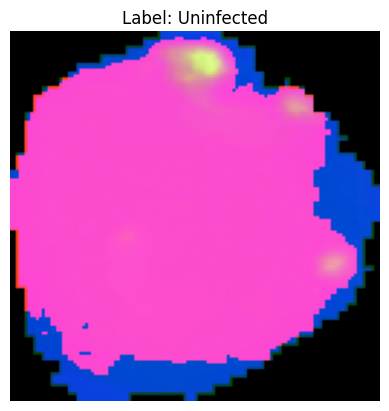

In [18]:
# Function to convert RGB images to HSV
def convert_to_hsv(image, label):
    hsv_image = tensorflow.image.rgb_to_hsv(image)  # Convert RGB to HSV
    return hsv_image, label

# Apply the conversion to the training dataset
train_dataset_hsv = train_dataset_norm.map(convert_to_hsv)

# func to plot hsv image
def plot_hsv_image(hsv_image, label):
    plt.imshow(hsv_image.numpy())
    plt.title(f"Label: {'Parasitized' if label.numpy()[0] == 1.0 else 'Uninfected'}")
    plt.axis('off')
    plt.show()

# Inspect a sample from the HSV dataset
for hsv_image, label in train_dataset_hsv.take(1):
    print("HSV Image Shape:", hsv_image.shape)
    print("Label:", label)
    plot_hsv_image(hsv_image, label)


###<b> Converting the test data

HSV Image Shape: (128, 128, 3)
Label: tf.Tensor([0.], shape=(1,), dtype=float32)


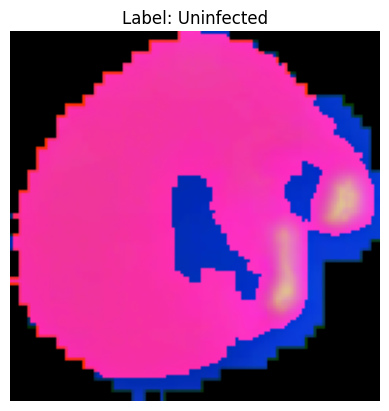

In [19]:
# Apply the conversion to the testing dataset
test_dataset_hsv = test_dataset_norm.map(convert_to_hsv)

# Inspect a sample from the HSV dataset
for hsv_image, label in test_dataset_hsv.take(1):
    print("HSV Image Shape:", hsv_image.shape)
    print("Label:", label)
    plot_hsv_image(hsv_image, label)

### Observations and insights:

converting to HSV can improve model performance by removing colour interdependence and increasing the impact of things like saturation and overall brightness of colours.

However, I did not use this for my training data because I found I achieved good performance without it.

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

###<b> Gaussian Blurring on test data

####**Observations and insights: _____**

**Think About It:** Would blurring help us for this problem statement in any way? What else can we try?

TODO

In [20]:
def splitDataset(_dataset, split_ratio):
    """
    Splits the dataset into training and validation datasets based on the given ratio.
    """
    dataset_size = len(_dataset)
    train_size = int(dataset_size * split_ratio)

    # Shuffle the dataset
    shuffled_dataset = _dataset.shuffle(buffer_size=dataset_size, reshuffle_each_iteration=False, seed=42)

    # Split the dataset
    train_dataset = shuffled_dataset.take(train_size)
    val_dataset = shuffled_dataset.skip(train_size)

    return train_dataset, val_dataset

# This is not required in the notebook instructions, but I will create my own validation set
# Split the training dataset into training and validation datasets

train_dataset_norm_split, val_dataset_norm_split = splitDataset(train_dataset_norm, 0.8)

# Check the number of samples in each split
train_dataset_split_size = sum(1 for _ in train_dataset_norm_split)
val_dataset_split_size = sum(1 for _ in val_dataset_norm_split)
print("Training dataset split size:", train_dataset_split_size)
print("Validation dataset split size:", val_dataset_split_size)

Training dataset split size: 19966
Validation dataset split size: 4992


## **Model Building**

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Importing the required libraries for building and training our Model

In [21]:
from keras.models import Sequential
# layers for simple NN
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, InputLayer, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping

####<B>One Hot Encoding the train and test labels

In [22]:
# no need to one-hot encode the labels for binary classification

In [23]:
import random

# set seed for reproducibility
def setSeed(seed: int = 42):
    np.random.seed(seed)
    random.seed(seed)
    tensorflow.random.set_seed(seed)

setSeed()

clear_session()



###<b> Building the model

In [24]:
def basicCNN():
    """
    Basic Convolutional Neural Network model for binary classification of images.
    """
    # Create a Sequential model
    _model = Sequential()

    # Input layer
    _model.add(InputLayer(shape=(128, 128, 3)))

    # First conv block
    _model.add(Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    _model.add(MaxPooling2D((2, 2)))
    _model.add(Dropout(0.3))

    # Second conv block
    _model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    _model.add(MaxPooling2D((2, 2)))

    # Global Average Pooling
    _model.add(Flatten())

    # Fully connected layers
    _model.add(Dense(64, activation='relu'))
    _model.add(Dropout(0.5))

    # Output layer
    _model.add(Dense(1, activation='sigmoid', name='cell_classes'))

    return _model
# Create the model
CNN_model_1 = basicCNN()



### Compiling the model

In [25]:
# Compile the model
CNN_model_1.compile(optimizer=Adam(learning_rate=1e-4),
                    loss=BinaryCrossentropy(),
                    metrics=[BinaryAccuracy()]
                )

CNN_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cell_classes (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,102,369 (8.02 MB)

 Trainable params: 2,102,369 (8.02 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks 

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#### Fit and train our Model

In [27]:
train_dataset_norm_split_batch = train_dataset_norm_split.batch(32)
val_dataset_norm_split_batch = val_dataset_norm_split.batch(32)

history_1 = CNN_model_1.fit(train_dataset_norm_split_batch,
                          epochs=10,
                          batch_size=32,
                          validation_data=val_dataset_norm_split_batch,
                          callbacks=[early_stopping]
                        )

Epoch 1/10


2025-04-11 15:31:24.305250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - binary_accuracy: 0.5292 - loss: 0.8754 - val_binary_accuracy: 0.6050 - val_loss: 0.6518
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - binary_accuracy: 0.5902 - loss: 0.7363 - val_binary_accuracy: 0.6340 - val_loss: 0.6272
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - binary_accuracy: 0.6107 - loss: 0.6905 - val_binary_accuracy: 0.6276 - val_loss: 0.6342
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - binary_accuracy: 0.6304 - loss: 0.6638 - val_binary_accuracy: 0.6589 - val_loss: 0.6189
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.6436 - loss: 0.6683 - val_binary_accuracy: 0.6967 - val_loss: 0.6023
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.6573 - loss: 0.6718 - val_binary_accuracy: 0.6851 - val_loss: 0.6208
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - binary_accuracy: 0.6618 - loss: 0.6829 - val_binary_accuracy: 0.7302 - val_loss: 0.6213
Epo

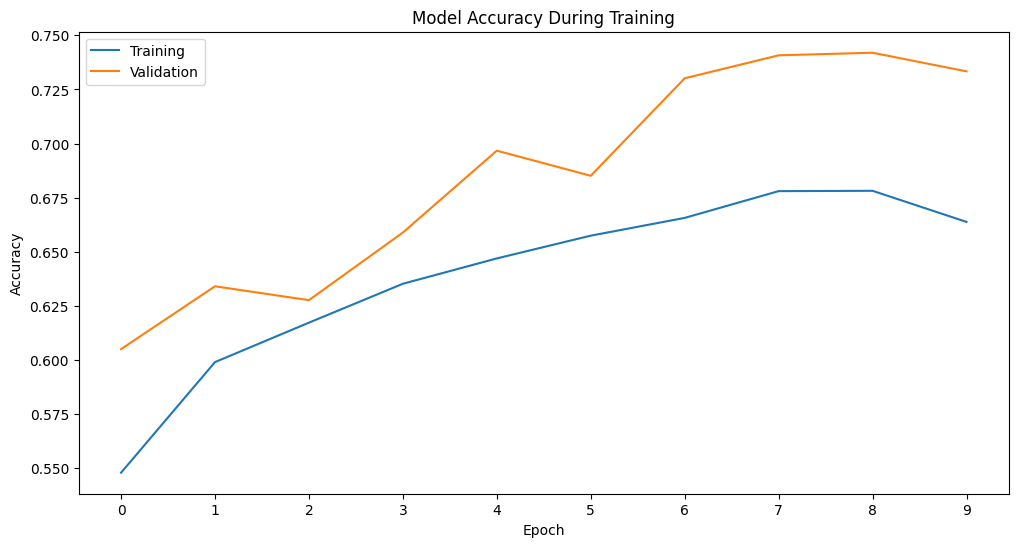

In [28]:
# helper function to plot the training history

def historyPlot(_history):
  plt.figure(figsize=(12, 6))  # Width, Height in inches
  plt.plot(_history.history['binary_accuracy'], label='Training')
  plt.plot(_history.history['val_binary_accuracy'], label='Validation')
  plt.title('Model Accuracy During Training')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.xticks(range(len(_history.history['binary_accuracy'])))
  plt.legend()
  plt.show()

historyPlot(history_1)

The above shows pretty unstable training initially but it performs well after epoch 6.

I will try training again with lower learning rate and more epochs.

Dropout layers only being active during training may explain why the validation accuracy is consistently higher.

In [29]:
CNN_model_1_e4 = basicCNN()
# Compile the model
CNN_model_1_e4.compile(optimizer=Adam(learning_rate=1e-4),
                    loss=BinaryCrossentropy(),
                    metrics=[BinaryAccuracy()]
                )

In [30]:
history_1_e4 = CNN_model_1_e4.fit(train_dataset_norm_split_batch,
                          epochs=15,
                          batch_size=32,
                          validation_data=val_dataset_norm_split_batch,
                          callbacks=[early_stopping]
                        )

Epoch 1/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - binary_accuracy: 0.5336 - loss: 0.8113 - val_binary_accuracy: 0.6112 - val_loss: 0.6482
Epoch 2/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - binary_accuracy: 0.6189 - loss: 0.6838 - val_binary_accuracy: 0.6635 - val_loss: 0.6272
Epoch 3/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.6338 - loss: 0.6543 - val_binary_accuracy: 0.7021 - val_loss: 0.6089
Epoch 4/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - binary_accuracy: 0.6602 - loss: 0.6251 - val_binary_accuracy: 0.7107 - val_loss: 0.5852
Epoch 5/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.6904 - loss: 0.5884 - val_binary_accuracy: 0.7500 - val_loss: 0.5401
Epoch 6/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - binary_accuracy: 0.7549 - loss: 0.5272 - val_binary_accuracy: 0.6534 - val_loss: 0.5112
Epoch 7/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - binary_accuracy: 0.8198 - loss: 0.4402 - val_binary_accuracy: 0.7742 - val_loss:

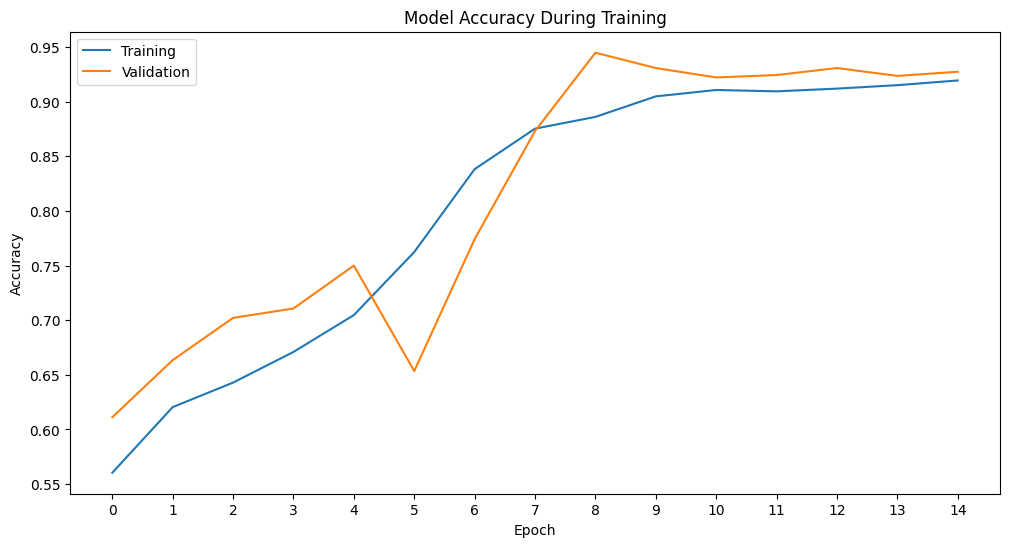

In [31]:
historyPlot(history_1_e4)

Shows more stable learnig indicated by the validation line. It also achieves a much higher accuracy by the end of learning. When the learning rate was 1e-3, the learning slowed down much sooner.

### Evaluating the model on test data

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def quickEvaluation(_model, _dataset, _batch_size=32):
    metrics = _model.evaluate(_dataset.batch(_batch_size))
    print("Test Loss:", metrics[0])
    print("Test Accuracy:", metrics[1])

quickEvaluation(CNN_model_1, test_dataset_norm, 32)
quickEvaluation(CNN_model_1_e4, test_dataset_norm, 32)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.6444 - loss: 0.6790
Test Loss: 0.6581297516822815
Test Accuracy: 0.6549999713897705
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9227 - loss: 0.2898
Test Loss: 0.3127098083496094
Test Accuracy: 0.9257692098617554


Much better initial results from using a lower learning rate and and a few more epochs.

In [33]:
# TODO tune the threshold to balance precision and recall
# this is important because we want to minimise false negatives

# Function to evaluate the model on a given dataset
def evaluateModel(_model, _dataset, batch=False):

    if batch:
        # If batch is True, batch the dataset
        _dataset = _dataset.batch(32)

    # Loop is needed to ensure the order of images and labels is maintained
    true_labels = []
    test_images = []
    for images, labels in _dataset:
        # Append images and labels to the lists
        true_labels.append(labels.numpy())
        test_images.append(images.numpy())


    # Concatenate the lists to create a single array
    true_labels = np.concatenate(true_labels)
    test_images = np.concatenate(test_images)

    # Generate predictions using the model
    pred_labels = _model.predict(test_images)

    # Convert predictions to binary labels (threshold = 0.5)
    pred_labels = (pred_labels > 0.5).astype(int).flatten()

    # Print classification report for precision, recall, F1-score, etc.
    print(classification_report(true_labels, pred_labels, target_names=['Uninfected', 'Parasitized']))

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Uninfected', 'Parasitized'],
                yticklabels=['Uninfected', 'Parasitized'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()




<b> Plotting the confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  Uninfected       0.68      0.59      0.63      1300
 Parasitized       0.64      0.72      0.68      1300

    accuracy                           0.66      2600
   macro avg       0.66      0.66      0.65      2600
weighted avg       0.66      0.66      0.65      2600



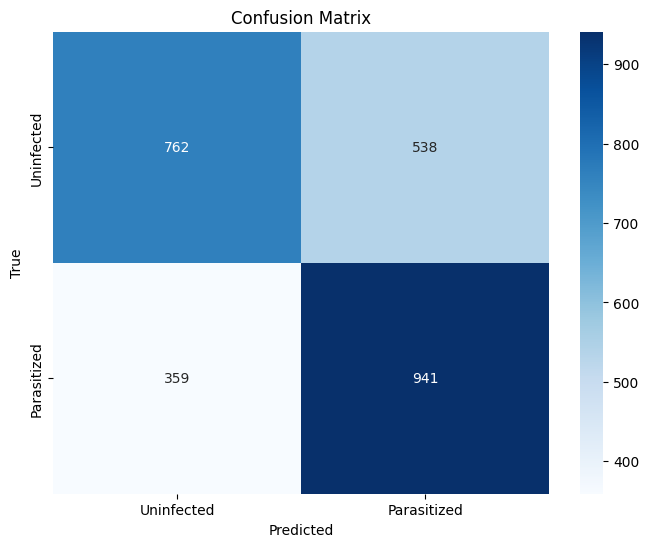

In [34]:
evaluateModel(CNN_model_1, test_dataset_norm, batch=True)

 1/82 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step

2025-04-11 15:36:35.580924: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  Uninfected       0.98      0.87      0.92      1300
 Parasitized       0.88      0.98      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



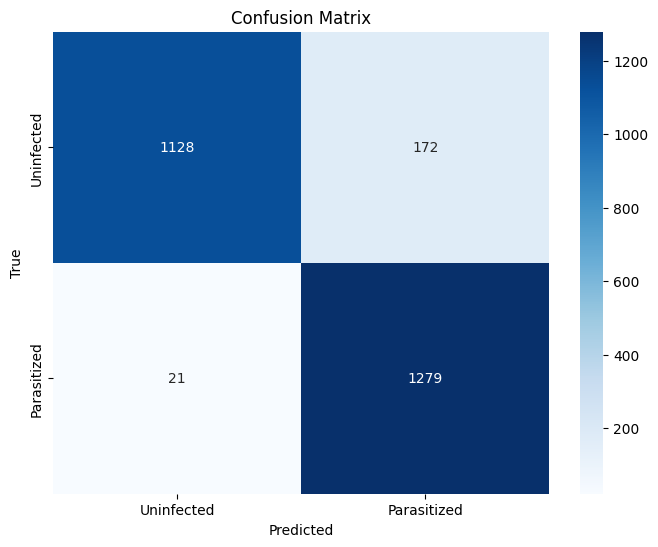

In [35]:
evaluateModel(CNN_model_1_e4, test_dataset_norm, batch=True)

The model with lower learning rate has high parasitized recall - which is important for diagnosing malaria!

<b>Plotting the train and validation curves

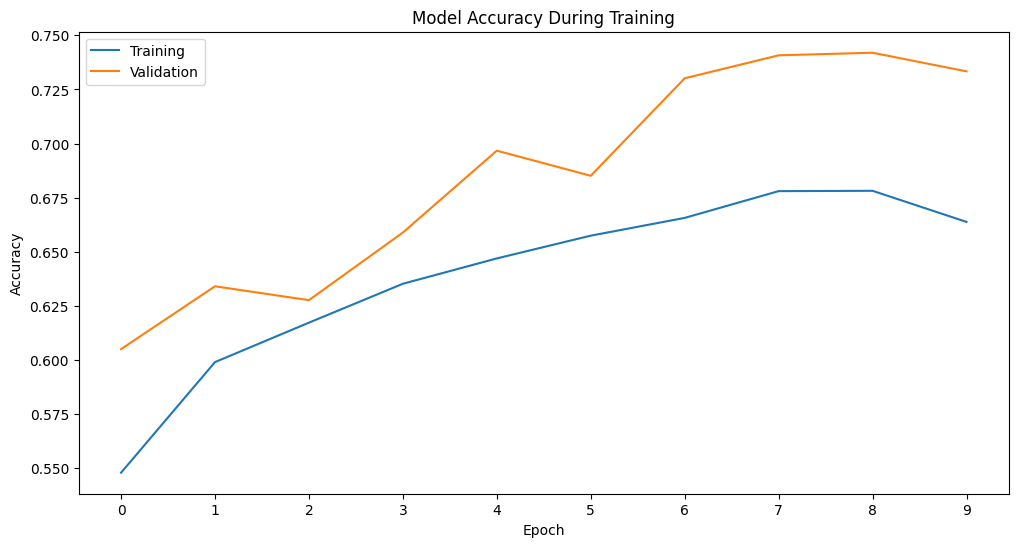

In [36]:
historyPlot(history_1)

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

### Model 2
Trying to improve the performance of our model by adding new layers


In [86]:
clear_session()
setSeed()

###<b> Building the Model

In [87]:
# added 2 extra conv layers to make model deeper

CNN_model_2 = Sequential()
CNN_model_2.add(InputLayer(shape=(128, 128, 3)))
# first conv block
CNN_model_2.add(Conv2D(16, (3, 3), activation='relu'))
CNN_model_2.add(MaxPooling2D((2, 2)))
# second conv block
CNN_model_2.add(Conv2D(32, (3, 3), activation='relu'))
CNN_model_2.add(MaxPooling2D((2, 2)))
# third conv block
CNN_model_2.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model_2.add(MaxPooling2D((2, 2)))
# fourth conv block
CNN_model_2.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model_2.add(MaxPooling2D((2, 2)))
# use avg pooling instead of flattening
CNN_model_2.add(Flatten())

CNN_model_2.add(Dense(256, activation='relu'))
CNN_model_2.add(Dropout(0.5))  # Dropout layer to prevent overfitting

CNN_model_2.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification


### Compiling the model

In [88]:
# Compile the model
CNN_model_2.compile(optimizer=Adam(learning_rate=3e-4),
                    loss=BinaryCrossentropy(),
                    metrics=[BinaryAccuracy()]
                )

CNN_model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,277,601 (4.87 MB)

 Trainable params: 1,277,601 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

<b> Using Callbacks

In [89]:
# adding early stopping
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

<b>Fit and Train the model

In [90]:
history_2 = CNN_model_2.fit(train_dataset_norm_split_batch,
                          epochs=15,
                          batch_size=32,
                          validation_data=val_dataset_norm_split_batch,
                          callbacks=[early_stopping_2]
                        )

Epoch 1/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - binary_accuracy: 0.6096 - loss: 0.8913 - val_binary_accuracy: 0.7704 - val_loss: 0.5423
Epoch 2/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - binary_accuracy: 0.7558 - loss: 0.5561 - val_binary_accuracy: 0.9513 - val_loss: 0.1302
Epoch 3/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.9557 - loss: 0.1416 - val_binary_accuracy: 0.9696 - val_loss: 0.0881
Epoch 4/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - binary_accuracy: 0.9697 - loss: 0.1035 - val_binary_accuracy: 0.9726 - val_loss: 0.0977
Epoch 5/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.9722 - loss: 0.0890 - val_binary_accuracy: 0.9766 - val_loss: 0.0811
Epoch 6/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.9738 - loss: 0.0810 - val_binary_accuracy: 0.9788 - val_loss: 0.0639
Epoch 7/15
624/624 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - binary_accuracy: 0.9746 - loss: 0.0798 - val_binary_accuracy: 0.9804 - val_loss:

###<b> Evaluating the model

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

  Uninfected       0.98      0.99      0.99      1300
 Parasitized       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



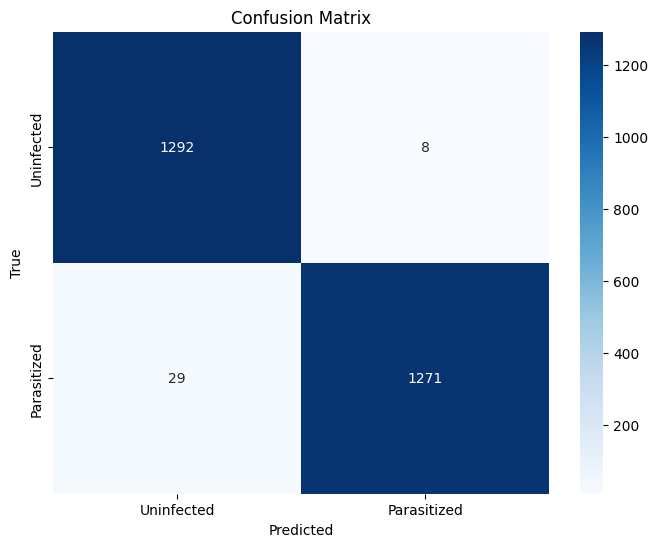

In [91]:
evaluateModel(CNN_model_2, test_dataset_norm, batch=True)


<b> Plotting the confusion matrix

<b> Plotting the train and the validation curves

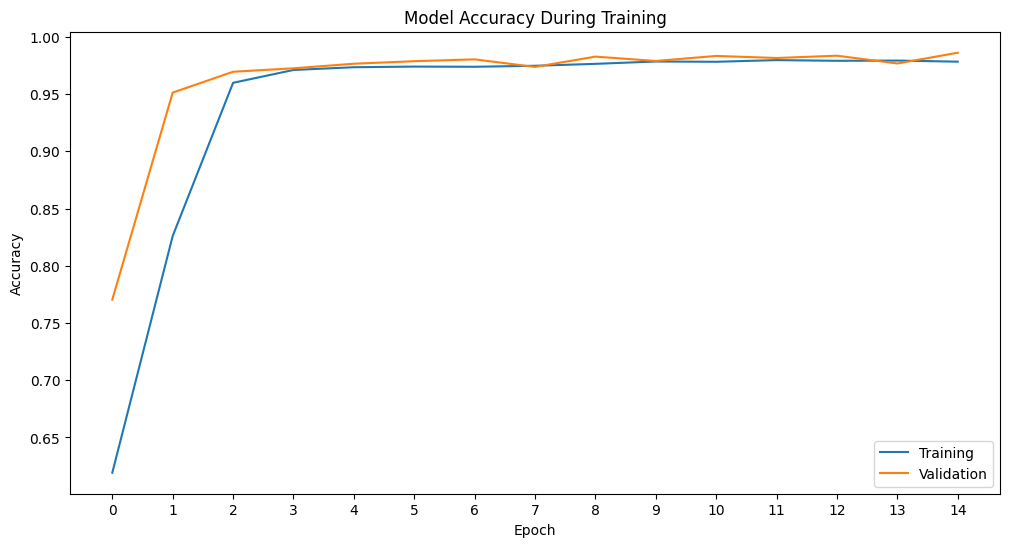

In [92]:
historyPlot(history_2)

###<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [44]:
clear_session()
setSeed()

###<b> Building the Model

In [45]:
def buildLeakyReluModel():
    """
    Builds a CNN model using LeakyReLU as the activation function and BatchNormalization.
    """
    model = Sequential()

    # Input layer
    model.add(InputLayer(shape=(128, 128, 3)))
    # first conv block
    model.add(Conv2D(16, (3, 3), activation=LeakyReLU(negative_slope=0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # second conv block
    model.add(Conv2D(32, (3, 3), activation=LeakyReLU(negative_slope=0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # third conv block
    model.add(Conv2D(64, (3, 3), activation=LeakyReLU(negative_slope=0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    # fourth conv block
    model.add(Conv2D(128, (3, 3), activation=LeakyReLU(negative_slope=0.1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    # use avg pooling instead of flattening
    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    return model

leaky_model = buildLeakyReluModel()

###<b>Compiling the model

In [46]:
# Compile the model
leaky_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss=BinaryCrossentropy(),
                    metrics=[BinaryAccuracy()]
                )

leaky_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,681 (514.38 KB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 480 (1.88 KB)

<b> Using callbacks

In [47]:
leaky_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

<b>Fit and train the model

In [48]:
leaky_history = leaky_model.fit(train_dataset_norm_split_batch,
                          epochs=10,
                          batch_size=32,
                          validation_data=val_dataset_norm_split_batch,
                          callbacks=[leaky_early_stopping]
                        )

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - binary_accuracy: 0.7918 - loss: 0.4763 - val_binary_accuracy: 0.7073 - val_loss: 1.0635
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - binary_accuracy: 0.9331 - loss: 0.1994 - val_binary_accuracy: 0.9481 - val_loss: 0.1428
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - binary_accuracy: 0.9576 - loss: 0.1312 - val_binary_accuracy: 0.9690 - val_loss: 0.0865
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - binary_accuracy: 0.9587 - loss: 0.1290 - val_binary_accuracy: 0.9685 - val_loss: 0.0854
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - binary_accuracy: 0.9597 - loss: 0.1237 - val_binary_accuracy: 0.9774 - val_loss: 0.0773
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - binary_accuracy: 0.9659 - loss: 0.1077 - val_binary_accuracy: 0.9728 - val_loss: 0.0830
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - binary_accuracy: 0.9640 - loss: 0.1064 - val_binary_accuracy: 0.9627 - val_loss:

<b>Plotting the train and validation accuracy

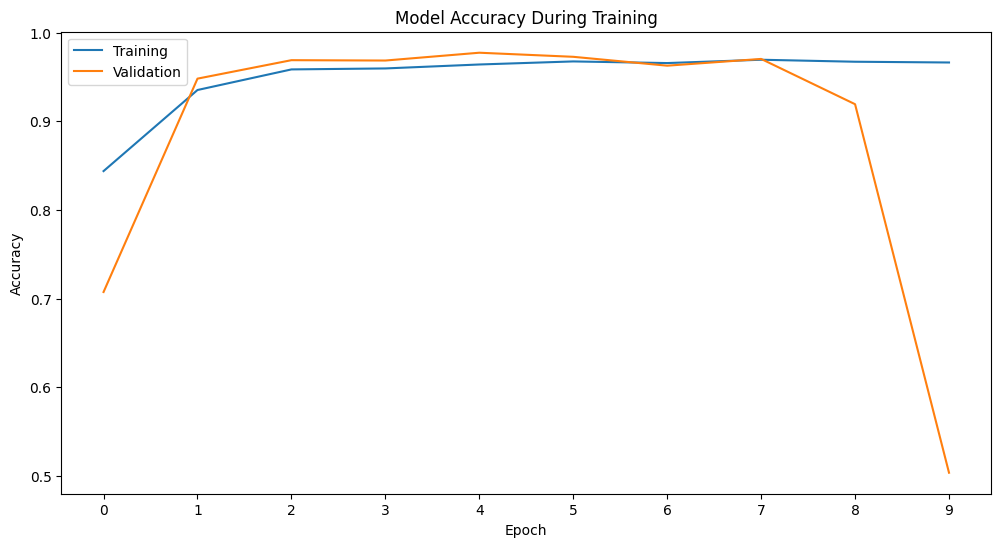

In [49]:
historyPlot(leaky_history)


###<b>Evaluating the model

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

  Uninfected       0.98      0.97      0.97      1300
 Parasitized       0.97      0.98      0.98      1300

    accuracy                           0.97      2600
   macro avg       0.98      0.97      0.97      2600
weighted avg       0.98      0.97      0.97      2600



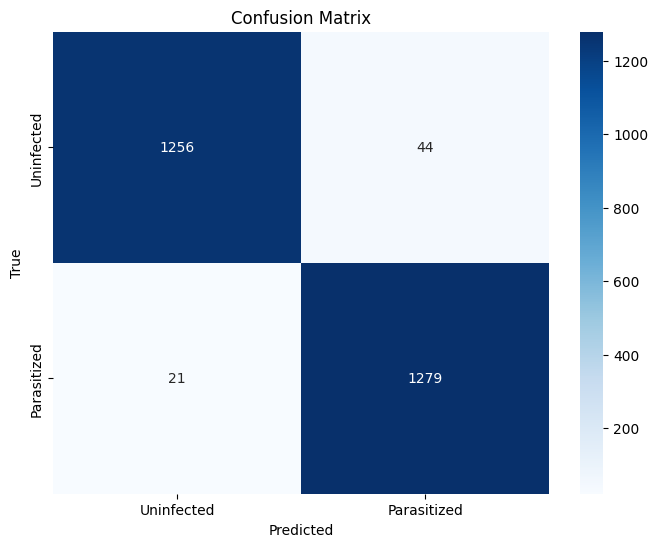

In [50]:
evaluateModel(leaky_model, test_dataset_norm, batch=True)

####<b>Observations and insights: ____

<b> Generate the classification report and confusion matrix 

###**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

###<b> Use image data generator

In [51]:
# Create an instance of ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,  # Split the training data into training and validation sets
)

# Create an instance of ImageDataGenerator for the test dataset (no augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
# Load the training dataset using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    seed=42,
    subset='training',  # Use the training subset
)

# Load the validation dataset using flow_from_directory
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    seed=42,
    subset='validation',  # Use the validation subset
)

# Load the testing dataset using flow_from_directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    seed=42,
    shuffle=False,  # Do not shuffle the test data
)

Found 19967 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

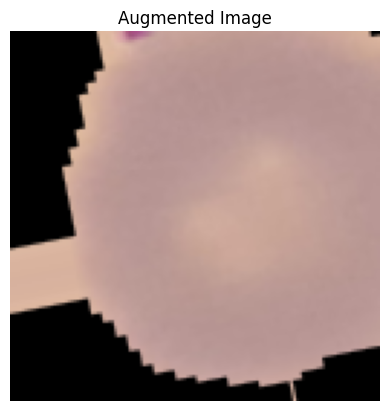

In [52]:
img_path = 'cell_images/train/parasitized/C2NThinF_IMG_20150604_115238_cell_259.png'
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

augmented_images = train_datagen.flow(img_array, batch_size=1)
# Display augmented images
for im in augmented_images:
    plt.imshow(im[0].astype('float32'))
    plt.title("Augmented Image")
    plt.axis('off')
    plt.show()
    break  # Display only one augmented image
# Visualize a sample image from the training dataset

####<b>Observations and insights: 

It looks quite different to the un-transformed blood cell images, it looks like it has been cropped. This may be helpful for training the model on low-quality blood cell images.

###<b>Building the Model

In [55]:
# Print the shape of one batch to check it
for x_batch in next(train_generator):
    print(x_batch.shape)

(32, 128, 128, 3)
(32,)


In [56]:
# will use the leaky model for this
clear_session()
setSeed()

new_leaky_model = buildLeakyReluModel()
# Compile the model
new_leaky_model.compile(optimizer=Adam(learning_rate=2e-4),
                    loss=BinaryCrossentropy(),
                    metrics=[BinaryAccuracy()]
                )

new_leaky_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,681 (514.38 KB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 480 (1.88 KB)

<b>Using Callbacks

<b> Fit and Train the model

In [57]:
data_aug_hist = new_leaky_model.fit(train_generator,
                batch_size=32,
                epochs=10,
                validation_data=val_generator,
                callbacks=[leaky_early_stopping],
                )

Epoch 1/10


/Users/rowandauria/Documents/GitHub/MIT Course Assignments/MIT ADSP Capstone Project/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - binary_accuracy: 0.7092 - loss: 0.5678 - val_binary_accuracy: 0.8449 - val_loss: 0.3713
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - binary_accuracy: 0.8503 - loss: 0.3703 - val_binary_accuracy: 0.8870 - val_loss: 0.2723
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - binary_accuracy: 0.8638 - loss: 0.3385 - val_binary_accuracy: 0.9062 - val_loss: 0.2431
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - binary_accuracy: 0.8953 - loss: 0.2720 - val_binary_accuracy: 0.8575 - val_loss: 0.3833
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 151s 243ms/step - binary_accuracy: 0.9029 - loss: 0.2562 - val_binary_accuracy: 0.9341 - val_loss: 0.2103
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - binary_accuracy: 0.9123 - loss: 0.2371 - val_binary_accuracy: 0.9126 - val_loss: 0.2380
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - binary_accuracy: 0.9033 - loss: 0.2760 - val_binary_accuracy: 0.9102 - val_loss: 0.2413
E

###<B>Evaluating the model

<b>Plot the train and validation accuracy

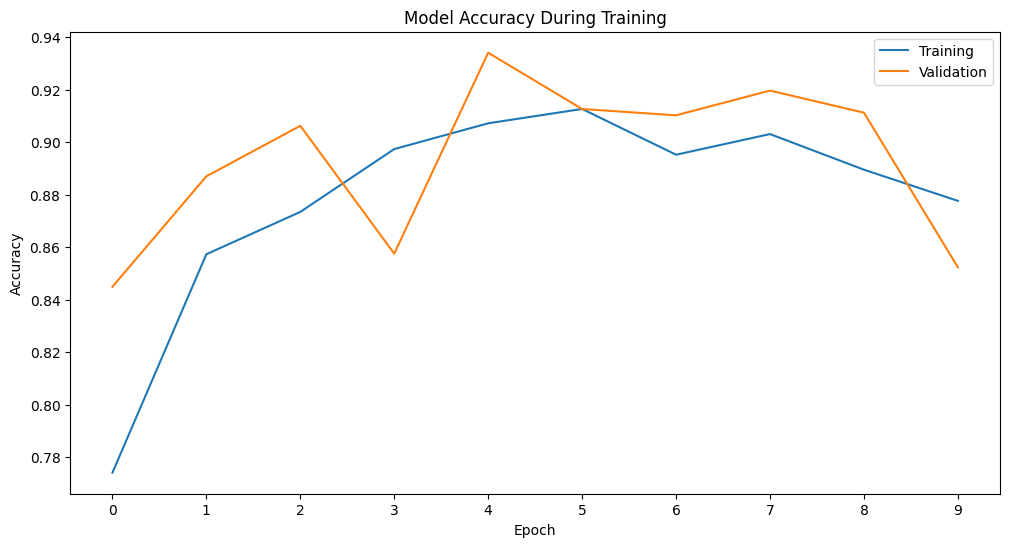

In [58]:
historyPlot(data_aug_hist)

<B>Plotting the classification report and confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

  Uninfected       0.97      0.97      0.97      1300
 Parasitized       0.97      0.97      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



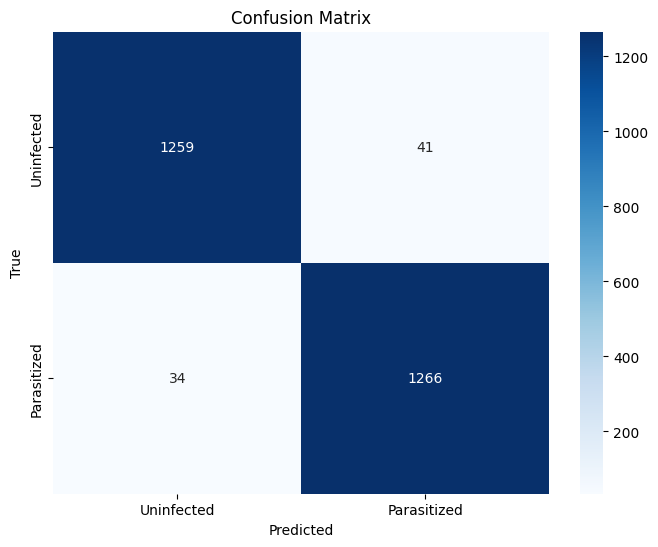

In [65]:
aug_data_pred = new_leaky_model.predict(test_generator)
aug_data_pred = (aug_data_pred > 0.5).astype(int).flatten()
# Print classification report for precision, recall, F1-score, etc.
print(classification_report(test_generator.classes, aug_data_pred, target_names=['Uninfected', 'Parasitized']))

cm_aug = confusion_matrix(test_generator.classes, aug_data_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Parasitized recall is the highest yet! This is a key metric for minimising very dangerous false negatives in medical data science, so this is great.

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**
- Import VGG16 network upto any layer you choose
- Add Fully Connected Layers on top of it

In [66]:
from tensorflow.keras.applications import VGG16

###<b>Compiling the model

In [67]:
vg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
vg_base.trainable = False  # Freeze the base model
# Add custom layers on top of the base model
vg_model = Sequential([
    vg_base,
    GlobalAveragePooling2D(),
    Dense(128, activation=LeakyReLU(negative_slope=0.1)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

vg_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=[BinaryAccuracy()]
)

vg_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

<b> using callbacks

In [68]:
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

<b>Fit and Train the model

In [69]:
# fit the model
data_aug_hist_vgg = vg_model.fit(train_generator,
                batch_size=32,
                epochs=10,
                validation_data=val_generator,
                callbacks=[early_stopping_vgg],
                )

Epoch 1/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - binary_accuracy: 0.6407 - loss: 0.6352 - val_binary_accuracy: 0.8167 - val_loss: 0.4522
Epoch 2/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - binary_accuracy: 0.8339 - loss: 0.4153 - val_binary_accuracy: 0.8581 - val_loss: 0.3699
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - binary_accuracy: 0.8656 - loss: 0.3391 - val_binary_accuracy: 0.8666 - val_loss: 0.3347
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - binary_accuracy: 0.8816 - loss: 0.3096 - val_binary_accuracy: 0.8768 - val_loss: 0.3096
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - binary_accuracy: 0.8848 - loss: 0.2911 - val_binary_accuracy: 0.8890 - val_loss: 0.2864
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - binary_accuracy: 0.8909 - loss: 0.2691 - val_binary_accuracy: 0.8834 - val_loss: 0.3003
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - binary_accuracy: 0.8991 - loss: 0.2585 - val_binary_accuracy: 0.8918 - val_loss:

<b>Plot the train and validation accuracy

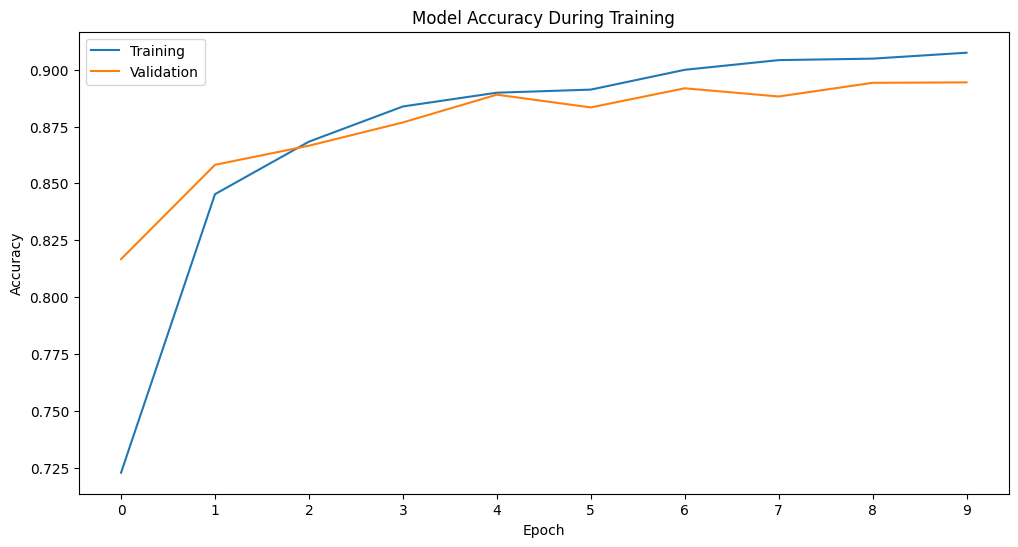

In [70]:
historyPlot(data_aug_hist_vgg)

### Observations and insights:

* Fairly smooth tranining curve with an expected validation result that is slightly worse that the fit of training data.
* Model is slightly overfitting but not sigificantly.

###<b> Evaluating the model

82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
              precision    recall  f1-score   support

  Uninfected       0.97      0.97      0.97      1300
 Parasitized       0.97      0.97      0.97      1300

    accuracy                           0.97      2600
   macro avg       0.97      0.97      0.97      2600
weighted avg       0.97      0.97      0.97      2600



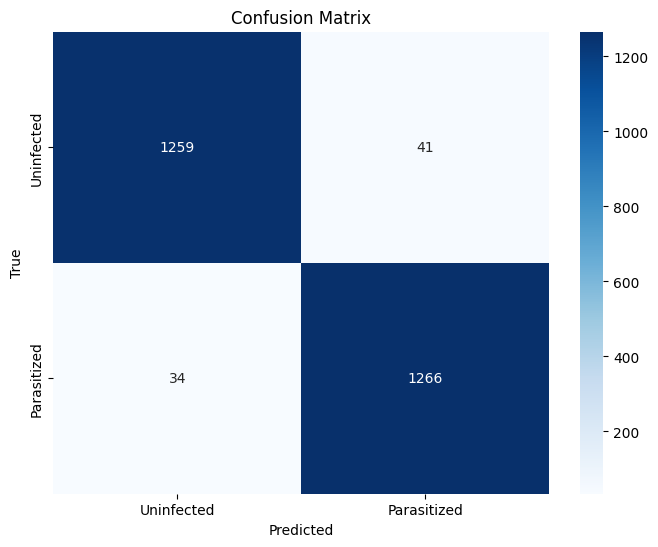

In [71]:
vg_pred = vg_model.predict(test_generator)
vg_pred = (aug_data_pred > 0.5).astype(int).flatten()
# Print classification report for precision, recall, F1-score, etc.
print(classification_report(test_generator.classes, vg_pred, target_names=['Uninfected', 'Parasitized']))

cm_vg_aug = confusion_matrix(test_generator.classes, vg_pred)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vg_aug, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Uninfected', 'Parasitized'],
            yticklabels=['Uninfected', 'Parasitized'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<b>Plotting the classification report and confusion matrix

## Evaluating models on augemented data

CNN_model_2 achieved the same accuracy score as the VGG16 model in key accuracy metrics, namely `Parasitized Recall`. However, to CNN_model_2 was only trained on the un-augmented data. So to compare them I will test them both on the augmented data, because it is more representative of real-world data.

In [96]:
clear_session()

c2_aug_pred = CNN_model_2.predict(test_generator)
c2_aug_pred = (c2_aug_pred > 0.5).astype(int).flatten()
# Print classification report for precision, recall, F1-score, etc.
print(classification_report(test_generator.classes, c2_aug_pred, target_names=['Uninfected', 'Parasitized']))

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

  Uninfected       0.98      0.99      0.99      1300
 Parasitized       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.99      0.98      0.98      2600
weighted avg       0.99      0.98      0.98      2600



Surprisingly, CNN_model_2 performed just as well on the augmented training data. This suggests that the augmentation trainsformations are not sufficiently distorting the images to stretch the capabilities of the models.

In [93]:
# save the model
vg_model.save('cell_model_vgg16.keras')

###<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


#### Observations and Conclusions drawn from the final model: _____

The VGG16 model is tied with the performs as well as the leaky model, but not as well as the second CNN. It is interesting that the VGG16 model achieves such high accuracy because most of the layers were not trained on the blood cell data. This highlights the role of the early CNN layers in identifying general shapes/patters in the data, rather than defining the final output.



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

## Insights

## Refined insights

#### What are the most meaningful insights from the data relevant to the problem?
- The data is of a high quality, and has clearly been pre-processed to crop and normalize the images, even before I made changes. This made for a clean training dataset.
- However, such clean training data may pose issues for generalisation of the model onto real-world data, that might not be as clean.

#### Comparison of various techniques and their relative performance
How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

- The second CNN with 4 Conv layers performs the best, which is surprising because it's not using any advanced optimisation. But I spent some time tuning the learning rate, which isn't true for the other models.

- The VGG16 achieves roughly the same performance as the model using LeakyRelu on the augmented test data, which has been distorted to generalise the model further. The both performed very slightly worse than the second CNN I used (97% vs 98% accuracy).

- The primary metrics for evaluation are accuracy/precision/recall on the augmented dataset, because this mimicks real-world data more effectively. Parasitized recall is the most important metric within the evaluation. The reason is that in a medical context, false negatives need to be avoided as much as possible, as these put patients at risk of undiagnosed illnesses.

- To maximise Parasitized recall further, the classification boundary could be tuned to be increase probability of a positive diagnosis. 


#### Proposal for the final solution design:
What model do you propose to be adopted? Why is this the best solution to adopt?

- I propose using the VGG16-based model with LeakyReLU activation, trained on the augmented dataset. This setup maintains high overall performance while achieving strong recall for the Parasitized class — a key priority for real-world medical deployment. Also, I suspect that the second CNN model is overfitting on the training data, but the testing data is too similar to expose this flaw. Also, as VGG16 is open-source and very popular, there are more resources for optmisation and troubleshooting, compared to building a completely custom model.

- The augmented dataset better reflects real-world variability, and using it ensures the model generalises beyond the clean training set. Combined with VGG16’s strong feature extraction capabilities, this offers a reliable baseline for deployment.

- Further tuning of the classification threshold can help maximise Parasitized recall without significantly compromising overall accuracy, aligning with the goal of minimizing false negatives in a clinical context.
